# Collecting Images on the hand signs from kaggle


## Preprocessing and Dataset Creation with Pytorch

In [1]:
import os
import cv2
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import time
from sklearn.model_selection import train_test_split

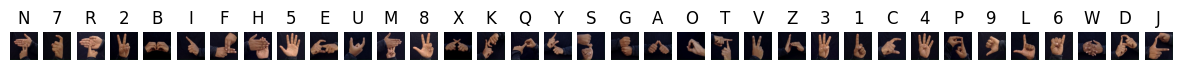

class count = 35


In [2]:
import cv2
dataset_dir = "/kaggle/input/indian-sign-language-dataset/data"

class_folders = os.listdir(dataset_dir)

fig,axes = plt.subplots(1, len(class_folders), figsize=(15,15))
count = 0

for i, class_folder in enumerate(class_folders):
  class_path = os.path.join(dataset_dir,class_folder)
  if os.path.isdir(class_path):
    image_files = os.listdir(class_path)
    if image_files:
      image_path=os.path.join(class_path,image_files[0])
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

      axes[i].imshow(image)
      axes[i].set_title(class_folder)
      axes[i].axis("off")
      count = count + 1

# plt.tight_layout()
plt.show()

print(f"class count = {count}")



In [3]:
class ISLDataset(Dataset):
    def __init__(self, dataset_dir=None, data=None, labels=None, transform=None):
        self.transform = transform
        self.data = []
        self.labels = []

        if dataset_dir:
            self.label_to_idx = {label: idx for idx, label in enumerate(os.listdir(dataset_dir))}
            for label in os.listdir(dataset_dir):
                label_path = os.path.join(dataset_dir, label)
                if os.path.isdir(label_path):
                    for img_name in os.listdir(label_path):
                        img_path = os.path.join(label_path, img_name)
                        self.data.append(img_path)
                        self.labels.append(self.label_to_idx[label])
        elif data is not None and labels is not None:
            self.data = data
            self.labels = labels
        else:
            raise ValueError("Either dataset_dir or both data and labels must be provided.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

# Define the transform
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize the dataset with the directory
data_dir = dataset_dir
dataset = ISLDataset(dataset_dir=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [4]:
# Preparing data and labels lists
all_data = []
all_labels = []

for label, class_folder in enumerate(class_folders):
    class_path = os.path.join(dataset_dir, class_folder)
    if os.path.isdir(class_path):
        image_files = os.listdir(class_path)
        for image_file in image_files:
            image_path = os.path.join(class_path, image_file)
            all_data.append(image_path)
            all_labels.append(label)

# Splitting data in to traning and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(all_data, all_labels, test_size=0.2, random_state=42)

In [5]:
# creating training and validation datasets and dataloaders
train_dataset = ISLDataset(data=train_data, labels=train_labels, transform=transform)
val_dataset = ISLDataset(data=val_data, labels=val_labels, transform=transform)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=32)

## Model Creation

In [6]:
import torch.nn as nn
from torchvision.models import ResNet18_Weights
import torchvision.models as pre_trained_models

class ISLModel(nn.Module):
  def __init__(self,num_classes):
    super(ISLModel,self).__init__()
    weights=ResNet18_Weights.DEFAULT
    self.basemodel = pre_trained_models.resnet18(weights=weights)
    self.basemodel.fc = nn.Linear(self.basemodel.fc.in_features,num_classes)

  def forward(self,x):
    return self.basemodel(x)

num_classes = len(os.listdir(data_dir))
model = ISLModel(num_classes)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


## Training Loop

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.00001)

epochs_count = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ISLModel(
  (basemodel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [8]:
# early stopping parameters
patience = 5  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_no_improve = 2

In [9]:
from tqdm import tqdm

for epoch in range(epochs_count):
    model.train()
    running_loss = 0.0
    start_time = time.time()
    print(f"Starting the training process for epoch: {epoch + 1}")

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs_count}", leave=False)
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss / (progress_bar.n + 1))

    end_time = time.time()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_progress_bar = tqdm(val_dataloader, desc=f"Validation {epoch + 1}/{epochs_count}", leave=False)
    
    with torch.no_grad():
        for images, labels in val_progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_progress_bar.set_postfix(val_loss=val_loss / (val_progress_bar.n + 1))

    avg_train_loss = running_loss / len(train_dataloader)
    avg_val_loss = val_loss / len(val_dataloader)
    
    print(f"Epoch [{epoch+1}/{epochs_count}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Time: {end_time - start_time:.2f} seconds")

    # Early stopping check
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), '/kaggle/working/isl_model.pth')  # Save the best model
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break

# Save the final model
torch.save(model.state_dict(), '/kaggle/working/isl_model.pth')


Starting the training process for epoch: 1


Epoch [1/10], Train Loss: 0.6846, Val Loss: 0.0313, Time: 219.92 seconds
Starting the training process for epoch: 2


Epoch [2/10], Train Loss: 0.0295, Val Loss: 0.0076, Time: 156.96 seconds
Starting the training process for epoch: 3


Epoch [3/10], Train Loss: 0.0104, Val Loss: 0.0029, Time: 157.00 seconds
Starting the training process for epoch: 4


Epoch [4/10], Train Loss: 0.0049, Val Loss: 0.0013, Time: 156.33 seconds
Starting the training process for epoch: 5


Epoch [5/10], Train Loss: 0.0028, Val Loss: 0.0007, Time: 157.92 seconds
Starting the training process for epoch: 6


Epoch [6/10], Train Loss: 0.0015, Val Loss: 0.0003, Time: 156.00 seconds
Starting the training process for epoch: 7


Epoch [7/10], Train Loss: 0.0009, Val Loss: 0.0002, Time: 155.96 seconds
Starting the training process for epoch: 8


Epoch [8/10], Train Loss: 0.0006, Val Loss: 0.0001, Time: 156.80 seconds
Starting the training process for epoch: 9


Epoch [9/10], Train Loss: 0.0003, Val Loss: 0.0001, Time: 157.65 seconds
Starting the training process for epoch: 10


Epoch [10/10], Train Loss: 0.0002, Val Loss: 0.0000, Time: 155.77 seconds


In [10]:
class_names = []

class_names = sorted(os.listdir(dataset_dir))

print(class_names)

['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
